Goal of this case study is to predict survivors based on Titanic dataset and compare different alghoritms with different hiperparameters. At the end we can choose the best one for this task.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

In [9]:
data = pd.read_csv('titanic.csv', 
                   decimal=',')
data.head() 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,0,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.55,NaN,S,NaN
1,3,0,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.25,NaN,S,"East Providence, RI"
2,3,0,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.25,NaN,S,"East Providence, RI"
3,3,1,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.25,NaN,S,"East Providence, RI"
4,3,1,"Abelseth, Miss. Karen Marie",female,16.0,0,0,348125,7.65,NaN,S,"Norway Los Angeles, CA"


1. Data preparation

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1046 non-null   int64  
 1   survived   1046 non-null   int64  
 2   name       1046 non-null   object 
 3   sex        1046 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1046 non-null   int64  
 6   parch      1046 non-null   int64  
 7   ticket     1046 non-null   object 
 8   fare       1045 non-null   float64
 9   cabin      272 non-null    object 
 10  embarked   1044 non-null   object 
 11  home.dest  685 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 98.2+ KB


In [11]:
y = data['survived'] #it's our variable that we'd like to predict

In [12]:
data['ticket'].nunique() #it's something like ID of ticket, we can't reasonably 
#use this information

732

In [13]:
data.drop(columns='ticket', axis=1, inplace=True)

In [14]:
data.drop(columns='fare', axis=1, inplace=True)
#First thing we can see is that fare - ticket price is object Dtype and should be float. 
#But I decided not to use this variable at all, beacouse: 1) we can't be sure about currency and
#correctness (probably it's the summarized price for all people from the ticket) 
#AND this variable is higly correlated with cabin and pclass. 

In [15]:
#There is big amount of Nan's BUT it could be very useful information so we'll try to do sth
#We'll only use the letter sign - we assume that it's a deck designation. 
data.cabin.str[0].value_counts()

C    86
B    63
D    42
E    38
A    19
F    18
G     5
T     1
Name: cabin, dtype: int64

In [16]:
data["deck"] = data.cabin.str[0].fillna("Unknown").replace({"G":"F", "T":"F"})
#There is very little
#samples in classes T and G so we can add them to class F. Nan's we turn into class Unknown.

In [17]:
data.drop(['cabin'], axis=1, inplace=True) #now we can delete column cabin

In [18]:
data['embarked'].fillna(data['embarked'].value_counts().index[0], inplace=True)
#Column 'embarked' it's the port from which passengers departed. It seems as usefull information
#but it's probably highly correlated with cabin (now deck) and it's probably more informative but 
#on the other hand it can be more informative for us than ID's of cabins that we've alreade 
#established it's hard to locate on ship
#We'll use this column and fill Nan's with most common value which is 'S'. There is only 2 Nan's
#so it shouldn't be a mistake.

In [19]:
#home.dest (home destination) is the column that 
#we will not use as it does not carry any information related to the disaster

In [20]:
X = pd.get_dummies(data [['pclass', 'sex', 'age', 'sibsp', 'parch', 
                          'embarked', 'deck']], drop_first=True)
X.head() #'sex','embarked' and 'deck' are categorical columns so they should be encoded.

,pclass,age,sibsp,parch,sex_male,embarked_Q,embarked_S,deck_B,deck_C,deck_D,deck_E,deck_F,deck_Unknown
0,3,42.0,0,0,1,0,1,0,0,0,0,0,1
1,3,13.0,0,2,1,0,1,0,0,0,0,0,1
2,3,16.0,1,1,1,0,1,0,0,0,0,0,1
3,3,35.0,1,1,0,0,1,0,0,0,0,0,1
4,3,16.0,0,0,0,0,1,0,0,0,0,0,1


2. Modeling

2.1 Decision Tree Classifier

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#now we split data into training and testing. We can assume basing on dataset size that 80:20 
#should be correct ratio

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold

In [87]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(acc_dt)
#~70% accuracy when we fit Decision Tree Classifier without parameter optimization

0.719047619047619


In [25]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)

model_dt_opt = DecisionTreeClassifier()
params = {"min_samples_leaf": np.arange(1, 21),
          'max_depth': np.arange(1, 16),
         'criterion': ['gini', 'entropy']}
optimizer_dt = GridSearchCV(model_dt, 
                         params, 
                         scoring="accuracy", 
                         cv=kfold, 
                         n_jobs=-1)
optimizer_dt.fit(X_train, y_train)

y_pred_dt = optimizer_dt.best_estimator_.predict(X_test)
print(optimizer_dt.best_params_)
print(accuracy_score(y_test, y_pred_dt))

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}
0.7761904761904762


In [88]:
model_dt_opt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=5)
model_dt_opt.fit(X_train, y_train)
y_pred_dt_opt = model_dt_opt.predict(X_test)
acc_dt_opt = accuracy_score(y_test, y_pred_dt_opt)
print(acc_dt_opt)
#Decision Tree Classifier with optimal parameters. Accuracy increases to ~79%

0.7857142857142857


2.2 Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [129]:
model_lr = LogisticRegression(max_iter=10e5)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(acc_lr)
#~78% accuracy when we use Linear Regression model without optimization

0.7857142857142857


In [29]:
#Optimization
kfold = StratifiedKFold(10, shuffle=True, random_state=123)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='saga'))
])
params = [
    {
        'model__penalty': ['none']
    },
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10, 100, 1000]
    }
]

optimizer_lr = GridSearchCV(pipeline,
                           params,
                           scoring='accuracy',
                           cv=kfold,
                           n_jobs=-1)
optimizer_lr.fit(X_train, y_train)
optimizer_lr.best_params_

{'model__C': 0.1, 'model__penalty': 'l2'}

In [133]:
model_lr_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='l2', C=0.1))
])
model_lr_opt.fit(X_train, y_train)
y_pred_lr_opt = model_lr_opt.predict(X_test)
acc_lr_opt = accuracy_score(y_test, y_pred_lr_opt)
print(acc_lr_opt)
#after optimization we are at the same level of accuracy

0.7714285714285715


In [31]:
from sklearn import metrics

In [32]:
cm = metrics.confusion_matrix(y_test, y_pred_lr)
print(cm)

[[96 21]
 [24 69]]


In [33]:
#Optimization
kfold = StratifiedKFold(10, shuffle=True, random_state=123)

solvers_list = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
C_params = [10e-2, 10e-1, 1, 10, 10e2, 10e3]

for solver in solvers_list:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(solver=solver))
    ])
    if solver in ['lbfgs', 'newton-cg', 'sag']:
        params = [
            {
                'model__penalty': ['none']
            },
            {
                'model__penalty': ['l2'],
                'model__C': C_params
            }
        ]
        
    elif solver == 'liblinear':
            params = [
            {
                'model__penalty': ['l1', 'l2'],
                'model__C': C_params
            }
        ]
    elif solver == 'saga':
            params = [
            {
                'model__penalty': ['none']
            },
            {
                'model__penalty': ['l1', 'l2'],
                'model__C': C_params
            }
        ]

    optimizer_lr = GridSearchCV(pipeline,
                                   params,
                                   scoring='accuracy',
                                   cv=kfold,
                                   n_jobs=-1)
    optimizer_lr.fit(X_train, y_train)
    print({'solver': solver,
           'best params': optimizer_lr.best_params_})
    y_pred_lr = optimizer_lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred_lr)
    print(f'Accuracy: {acc}')

{'solver': 'lbfgs', 'best params': {'model__C': 0.1, 'model__penalty': 'l2'}}
Accuracy: 0.7714285714285715
{'solver': 'liblinear', 'best params': {'model__C': 1.0, 'model__penalty': 'l2'}}
Accuracy: 0.7761904761904762
{'solver': 'newton-cg', 'best params': {'model__C': 0.1, 'model__penalty': 'l2'}}
Accuracy: 0.7714285714285715
{'solver': 'sag', 'best params': {'model__C': 0.1, 'model__penalty': 'l2'}}
Accuracy: 0.7714285714285715
{'solver': 'saga', 'best params': {'model__C': 0.1, 'model__penalty': 'l2'}}
Accuracy: 0.7714285714285715


In [99]:
#as we can see the best logistic regression parameters for this task is solver liblinear with C parameter 1 and l2 model penalty
#We can create new model with optimal parameters
model_lr_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver = 'liblinear', C=1, penalty = 'l2'))
])

model_lr_opt.fit(X_train, y_train)
y_pred_lr_opt = model_lr_opt.predict(X_test)
acc_lr_opt = accuracy_score(y_pred_lr_opt, y_test)
print(acc_lr_opt)

0.7761904761904762


2.3 SVM

In [35]:
#SVC

In [36]:
from sklearn.svm import SVC

In [127]:
model_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(max_iter=10e5))
])
model_SVC.fit(X_train, y_train)
y_pred_SVC = model_SVC.predict(X_test)
acc_SVC = accuracy_score(y_test, y_pred_SVC)
print(acc_SVC)

0.780952380952381


In [39]:
#SVC optimization

model_SVC_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(max_iter=10e7))
])
params = {'model__C':[1,10,100,1000],
          'model__gamma':[1,0.1,0.001,0.0001], 
          'model__kernel':['linear','rbf']}

optimizer_SVC = GridSearchCV(model_SVC_opt,
                             params,
                             scoring='accuracy',
                             cv=kfold,
                             n_jobs=-1
)
optimizer_SVC.fit(X_train, y_train)    
y_pred_SVC_opt = optimizer_SVC.predict(X_test)
accuracy_score(y_test, y_pred_SVC_opt)

In [40]:
optimizer_SVC.best_params_

In [128]:
pipeline_SVC_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(max_iter=10e7, C=1, gamma=0.1, kernel='rbf'))
])
model_SVC_opt.fit(X_train, y_train)
y_SVC_opt = model_SVC_opt.predict(X_test)
acc_SVC_opt = accuracy_score(y_test, y_SVC_opt)
print(acc_SVC_opt)

0.780952380952381


2.4 Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [43]:
# We'll use Random Forest Classifier with optimal parameters found in point 2.1.
#The problem is to find optimal number of estimators.

In [44]:
{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5}
0.7904761904761904

0.7904761904761904

In [45]:
N_estimators = np.arange(3, 802 , 25)
accuracies = []
for n_trees in N_estimators:
    model_rfc = RandomForestClassifier(n_trees, criterion='gini', 
                                       max_depth=12, min_samples_leaf=5)
    model_rfc.fit(X_train, y_train)
    y_pred_rfc = model_rfc.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred_rfc))

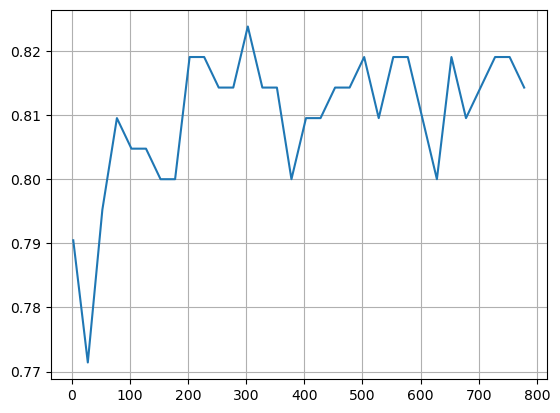

In [46]:
plt.style.use('default')
plt.plot(N_estimators, accuracies)
plt.grid()
plt.show()
#We can see some peaks but it's hard to interpret what number of trees is the 
#best, but probably there is no sense to test wider range than 800.

In [47]:
#Let's find parameters by GridSearch
model_rfc_opt = RandomForestClassifier(n_trees, criterion='gini', 
                                       max_depth=12, min_samples_leaf=5)
params = {'n_estimators': np.arange(100, 801, 25)}
optimizer_rfc = GridSearchCV(model_rfc_opt,
                            params,
                            scoring='accuracy',
                            cv=kfold,
                            n_jobs=-1)
optimizer_rfc.fit(X_train, y_train)
y_pred_rfc = optimizer_rfc.best_estimator_.predict(X_test)

In [48]:
optimizer_rfc.best_params_

{'n_estimators': 475}

In [123]:
#Let's create model with optimal parameters
model_rfc_opt = RandomForestClassifier(475, criterion='gini', 
                                       max_depth=12, min_samples_leaf=5)
model_rfc_opt.fit(X_train, y_train)
y_pred_rfc = model_rfc_opt.predict(X_test)
acc_rfc_opt = accuracy_score(y_test, y_pred_rfc)
print(acc_rfc_opt)

0.8238095238095238


2.5 Bagging

In [50]:
#Now we will test Bagging with SVM estimator and check accuracy

In [51]:
from sklearn.ensemble import BaggingClassifier

In [103]:
model_bagging = BaggingClassifier(pipeline_SVC_opt)
model_bagging.fit(X_train, y_train)
y_pred_bagging = model_bagging.predict(X_test)
acc_bagging = accuracy_score(y_test, y_pred_bagging)
print(acc_bagging)

0.7904761904761904


In [53]:
#Now let's find optimal parameters

In [55]:
svc = SVC(max_iter=10e7, C=1, gamma=0.1, kernel='rbf')
model_bagging_opt = BaggingClassifier(svc)
params = {'n_estimators': np.arange(10, 801, 25),
         'max_samples': np.arange(0, 1, 0.1),
         'max_features': np.arange(0, 1, 0.05)}

optimizer_bagging = GridSearchCV(model_bagging_opt,
                                params,
                                scoring='accuracy',
                                cv=kfold,
                                n_jobs=-1)
optimizer_bagging.fit(X_train, y_train)
y_pred_bagging_opt = optimizer_bagging.predict(X_test)
accuracy_score(y_test, y_pred_bagging_opt)

In [57]:
optimizer_bagging.best_params_

In [104]:
model_bagging_opt = BaggingClassifier(base_estimator=pipeline_SVC_opt, n_estimators=60, 
                                      max_samples=0.7, max_features=0.55)
model_bagging_opt.fit(X_train, y_train)
y_pred_bagging_opt = model_bagging.predict(X_test)
acc_bagging_opt = accuracy_score(y_test, y_pred_bagging_opt)
print(acc_bagging_opt)

0.7904761904761904


Models summary

In [124]:
models = ['Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Decision Tree',
         'RandomForest', 'SVC', 'SVC', 'Bagging', 'Bagging']
cond = ['No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes']
accuracies = [acc_lr, acc_lr_opt, acc_dt, acc_dt_opt, acc_rfc_opt, acc_SVC, acc_SVC_opt,
            acc_bagging, acc_bagging_opt]
models_sum = pd.DataFrame({'Models': models, 'Optimization': cond, 'Accuracy': accuracies})
models_sum = models_sum.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
models_sum

,Models,Optimization,Accuracy
0,RandomForest,Yes,0.823810
1,Bagging,No,0.790476
2,Bagging,Yes,0.790476
3,Logistic Regression,No,0.785714
4,Decision Tree,Yes,0.785714
5,SVC,No,0.780952
6,SVC,Yes,0.780952
7,Logistic Regression,Yes,0.776190
8,Decision Tree,No,0.719048


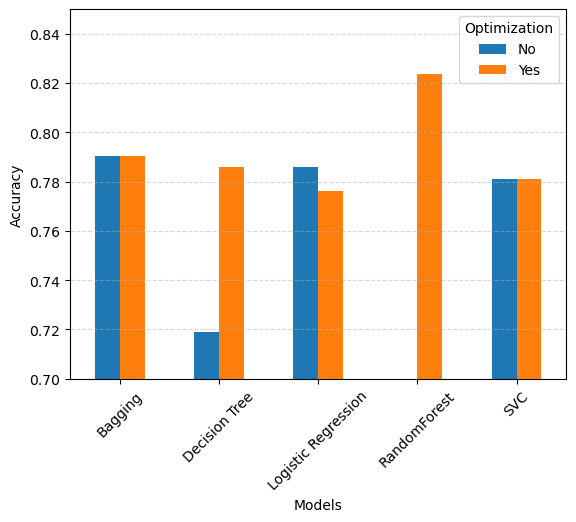

In [125]:
models_sum.pivot(index='Models', columns='Optimization', 
                 values='Accuracy').plot(kind='bar', rot=0)
plt.ylim([0.7, 0.85])
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.5);

Conslusions: Among all the tested models RandomForest turned out to be the best (accuracy ~ 82,4%). Optimal performance of the alghortim was obtained with 475 trees, Gini criterion, maximum depth 12 and the minimum number of samples to split a node 5.There is significant difference in the non-optimized and optimized DecisionTree alghoritm, while in the others there are no big differences.
